In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2021-11-14 18:43:07.975854: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


2.5.0


In [2]:
path = 'Dataset3/'
x1_train = pd.read_csv(path+'data_trainmid_x1.csv')
x2_train = pd.read_csv(path+'data_trainmid_x2.csv')
f1_train = pd.read_csv(path+'data_trainmid_f1.csv')
f1_test = pd.read_csv(path+'data_testmid_f1.csv')
x1_test = pd.read_csv(path+'data_testmid_x1.csv')
x2_test = pd.read_csv(path+'data_testmid_x2.csv')
print(len(x1_train),len(x1_test),len(f1_train),len(f1_test))
X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1),columns = ['p1','p2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1),columns = ['p1','p2'])
X_train.head()

112459 62211 112459 62211


,p1,p2
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [3]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    importances = rf.feature_importances_
    plt.figure(figsize=(20,5))
    x_plot = ['x1(n{})'.format(-i) for i in range(0,m*t,t)] + ['x2(n{})'.format(-i) for i in range(0,m*t,t)]
    plt.plot(x_plot,importances, label = 'Importance Plot')
    plt.legend()
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.title('Importance plot for random forest')
    plt.show()
    
    # RBF MODEL
    t1 = datetime.now()
    clf = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('Time taken by RBF Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y2 = y1_pred
    print('Root mean square error: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    # Deep Learning Model
    inp = Input((m*2))
    x = Dense(9,activation = 'relu')(inp)
    x = Dense(12,activation = 'relu')(x)
    x = Dense(1)(x)

    model = Model(inputs = inp, outputs = x)
    model.compile(optimizer = 'adam', loss = 'mse')
    t3 = datetime.now()
    his = model.fit(x_train,y_train, epochs=15)
    t4 = datetime.now()
    print('Time taken by Deep Learning Model',t4-t3)
    y1_pred = model.predict(x_test)
    y3 = y1_pred
    print('Root mean squared error:',sqrt(mean_squared_error(y_test,y1_pred)))
    error2 = []
    for i in range(len(y_test)):
        error2.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error2))
    print('Maximum Error =',max(error2))
    error3 = sorted(error2)
    print('Median Value of Error =',error3[len(error)//2])
    
    # COMPARISON
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF')
    plt.plot(list(range(6000)),y3[:6000], label = 'Deep Learning')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    plt.plot(list(range(len(y1_pred))),error, label = 'Error of Random Forest')
    plt.plot(list(range(len(y1_pred))),error2, label = 'Error of Deep Learning')
    plt.plot(list(range(len(y1_pred))),error5, label = 'Error of RBF Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error2[:6000], label = 'Deep Learning model')
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

# Six stages of past inputs

Time taken by Random Forest 0:01:38.372633
Root Mean Squared error of Random Forest 0.061089587357354445
Minimum Error = 1.1102230246251565e-16
Maximum Error = 0.950170000000002
Median Value of Error = 0.01938499999999932


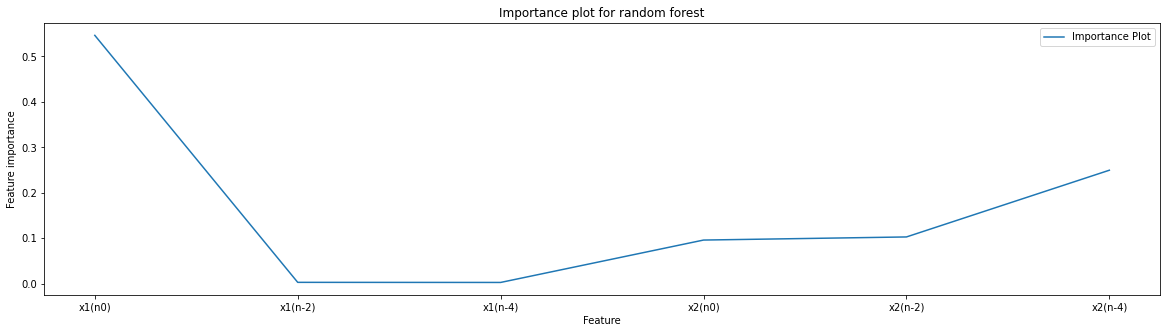

Time taken by RBF Model:  0:00:50.848499
Root mean square error:  0.052229884360948685
Minimum Error = 4.9456490347488113e-08
Maximum Error = 0.6888342849596538
Median Value of Error = 0.03268404620088594


2021-11-14 18:47:32.970538: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-14 18:47:33.225693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-14 18:47:33.229267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-14 18:47:33.232704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:07:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2

Epoch 1/15
3515/3515 [==============================] - 5s 1ms/step - loss: 0.3019
Epoch 2/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0150
Epoch 3/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0118
Epoch 4/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0100
Epoch 5/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0093
Epoch 6/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0080
Epoch 7/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0077
Epoch 8/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0074
Epoch 9/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0067
Epoch 10/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0063
Epoch 11/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0062
Epoch 12/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0061
E

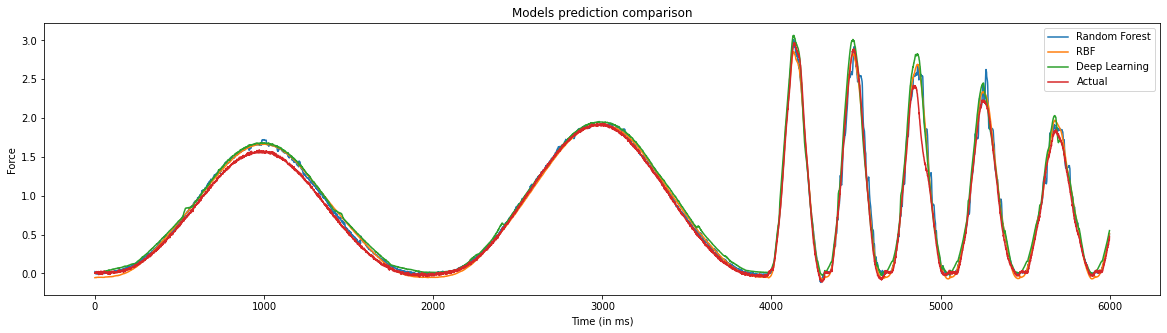

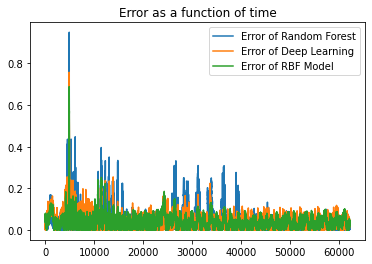

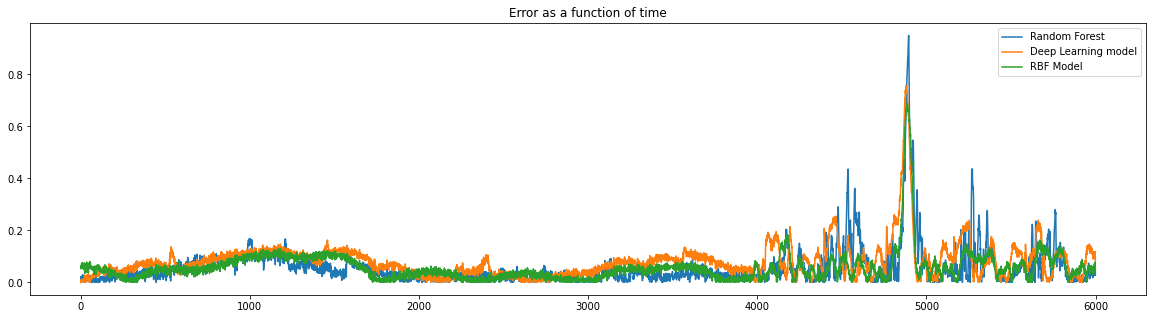

In [4]:
get_results(t=2, m=3)

Time taken by Random Forest 0:01:38.287576
Root Mean Squared error of Random Forest 0.06076392560527954
Minimum Error = 5.551115123125783e-17
Maximum Error = 0.9317850000000025
Median Value of Error = 0.019551000000000054


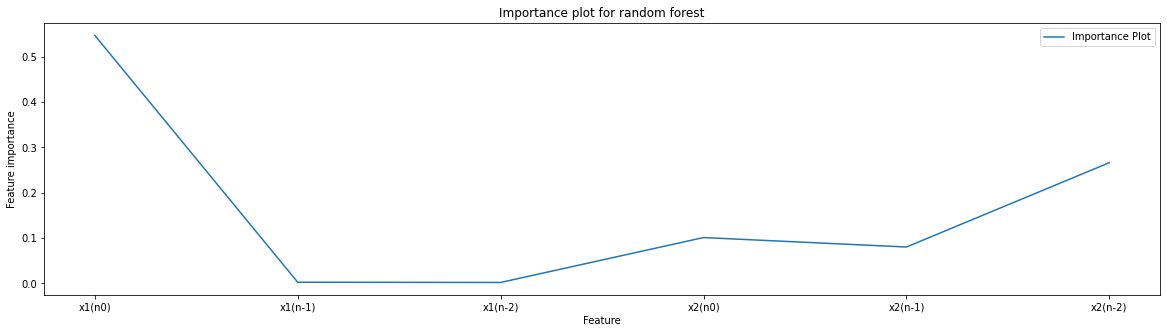

Time taken by RBF Model:  0:00:54.679525
Root mean square error:  0.05217516393256147
Minimum Error = 1.2039682774633853e-06
Maximum Error = 0.6889943090333859
Median Value of Error = 0.03260847328072136
Epoch 1/15
3515/3515 [==============================] - 7s 2ms/step - loss: 0.2355
Epoch 2/15
3515/3515 [==============================] - 7s 2ms/step - loss: 0.0200
Epoch 3/15
3515/3515 [==============================] - 7s 2ms/step - loss: 0.0142
Epoch 4/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0112
Epoch 5/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0099
Epoch 6/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0085
Epoch 7/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0078
Epoch 8/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0070
Epoch 9/15
3515/3515 [==============================] - 6s 2ms/step - loss: 0.0067
Epoch 10/15
3515/3515 [==========================

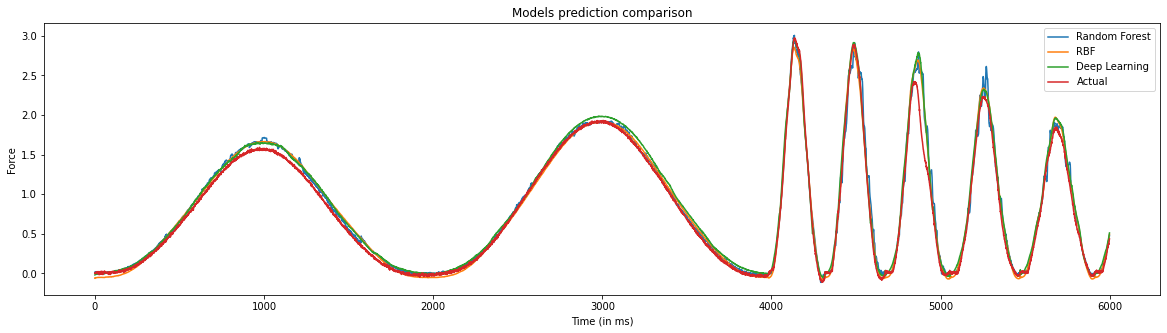

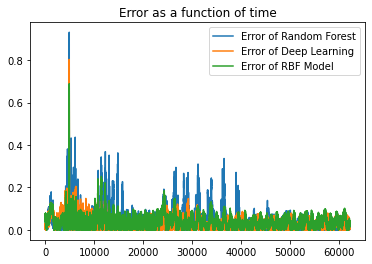

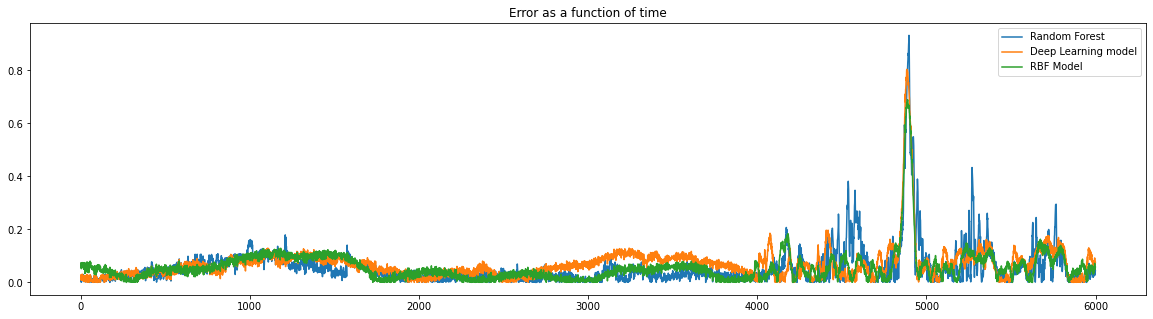

In [5]:
get_results(t=1, m=3)

Time taken by Random Forest 0:02:44.306590
Root Mean Squared error of Random Forest 0.059798988301475356
Minimum Error = 1.0408340855860843e-17
Maximum Error = 0.9041680000000019
Median Value of Error = 0.019074000000000146


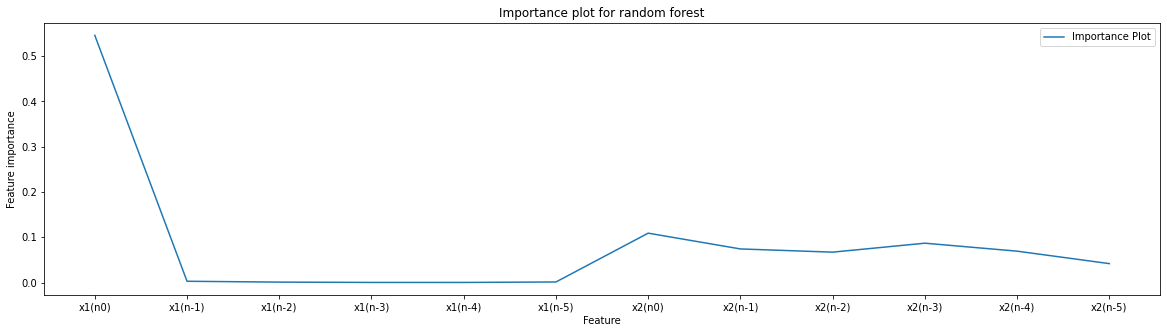

Time taken by RBF Model:  0:00:45.128703
Root mean square error:  0.05032844131323425
Minimum Error = 3.9406353108395464e-07
Maximum Error = 0.7033726623192846
Median Value of Error = 0.030082582839258687
Epoch 1/15
3515/3515 [==============================] - 5s 1ms/step - loss: 0.7444
Epoch 2/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0201
Epoch 3/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0149
Epoch 4/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0107
Epoch 5/15
3515/3515 [==============================] - 5s 1ms/step - loss: 0.0085
Epoch 6/15
3515/3515 [==============================] - 5s 1ms/step - loss: 0.0079
Epoch 7/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0072
Epoch 8/15
3515/3515 [==============================] - 5s 1ms/step - loss: 0.0067
Epoch 9/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0062
Epoch 10/15
3515/3515 [=========================

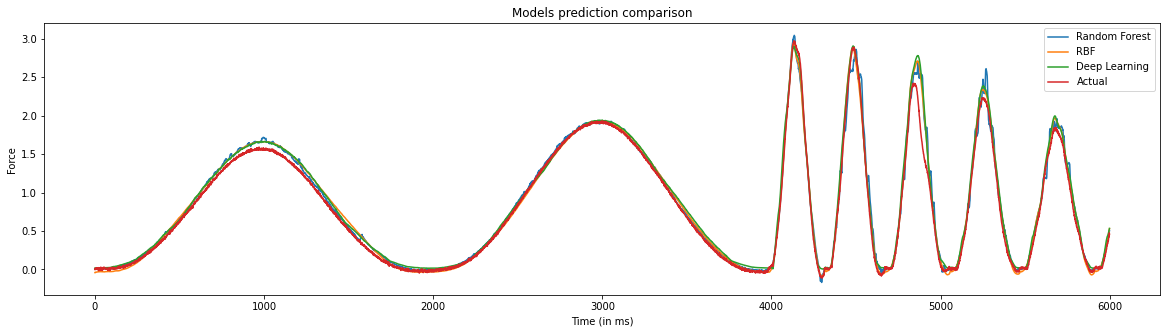

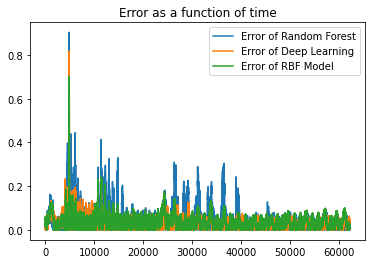

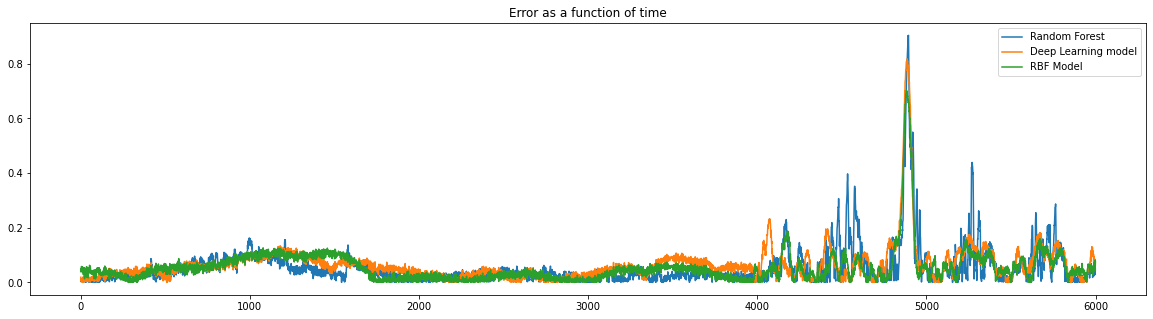

In [6]:
get_results(t=1,m=6)

Time taken by Random Forest 0:01:00.931467
Root Mean Squared error of Random Forest 0.06196006131579594
Minimum Error = 0.0
Maximum Error = 0.9286750000000017
Median Value of Error = 0.02100699999999997


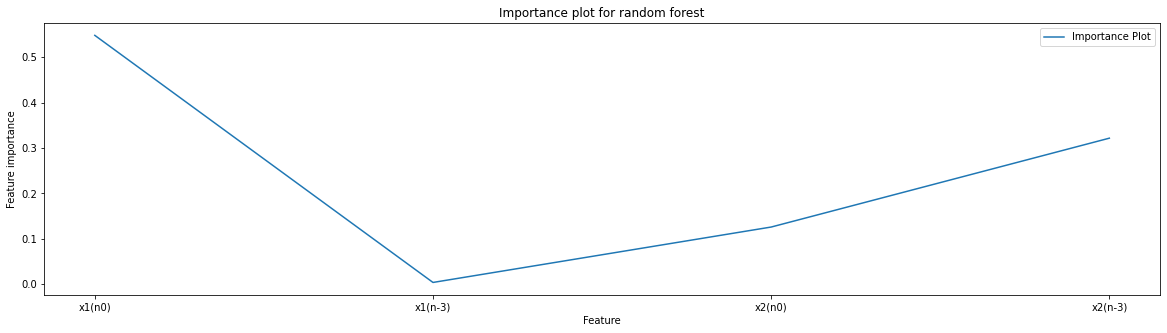

Time taken by RBF Model:  0:00:49.033857
Root mean square error:  0.052325179124678316
Minimum Error = 1.4075673582247816e-07
Maximum Error = 0.6970875298690633
Median Value of Error = 0.03304713465687403
Epoch 1/15
3515/3515 [==============================] - 5s 1ms/step - loss: 0.0282
Epoch 2/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0123
Epoch 3/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0099
Epoch 4/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0088
Epoch 5/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0078
Epoch 6/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0077
Epoch 7/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0075
Epoch 8/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0068
Epoch 9/15
3515/3515 [==============================] - 4s 1ms/step - loss: 0.0069
Epoch 10/15
3515/3515 [=========================

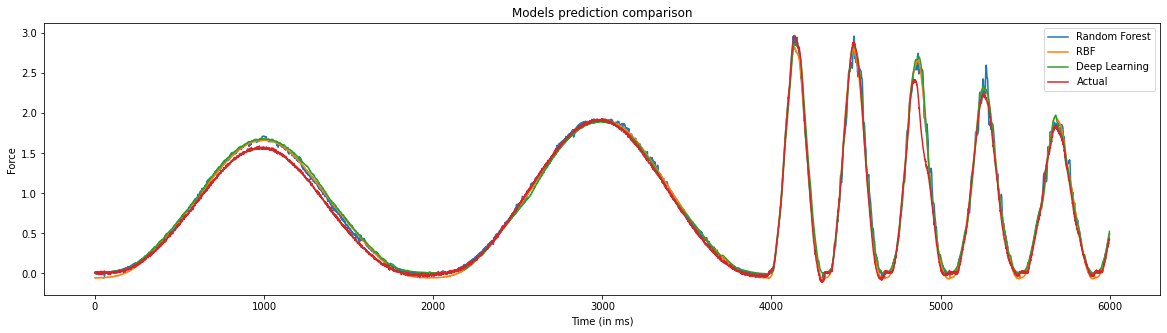

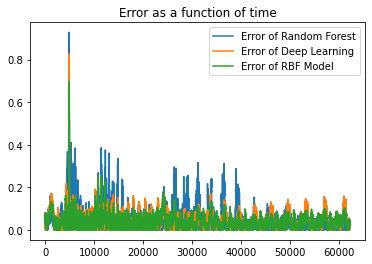

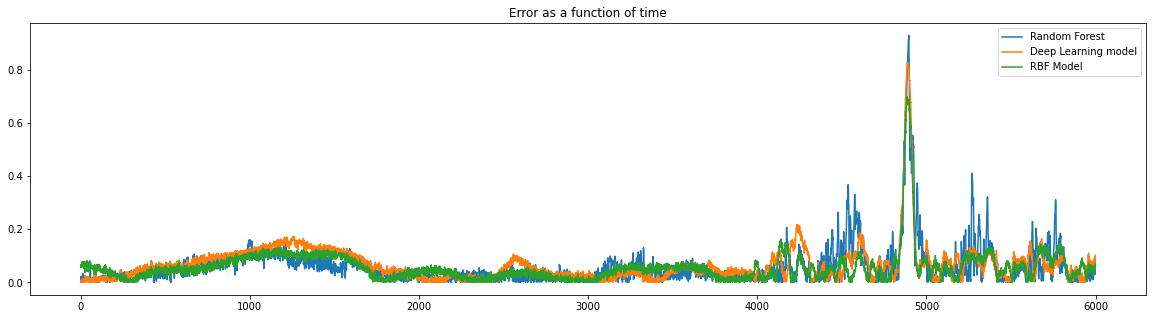

In [7]:
get_results(t=3,m=2)